In [0]:
# 我們會從https下載資料庫, MAC電腦需要加入以下兩行, 才不會把對方的ssl憑證視為無效
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [0]:
from keras.datasets import mnist
# 回傳值: ((訓練特徵, 訓練目標), (測試特徵, 測試目標))
(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [12]:
x_train.shape

(60000, 28, 28)

In [0]:
from keras.utils import np_utils
# reshape讓他從 32 * 32變成 784 * 1的一維陣列
# 讓我們標準化到-1~1區間
# 要不要轉化成為float32都可以
x_train_shaped = (x_train.reshape(60000, 784).astype("float32") - 127.5)/127.5
x_test_shaped = (x_test.reshape(10000, 784).astype("float32") - 127.5)/127.5

In [14]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization

# Generator: 反向MLP
# 隨機輸入的位置個數
random_dim = 100
# 這裡我採用每一層是上一層的兩倍神經元(類似VGG)的概念
# 並不是一定, 讀者可以根據自己的喜好調整
generator = Sequential()
generator.add(Dense(256, input_dim=random_dim, 
                    activation='relu'))
# 加上BN, 讓每一層輸入都標準化過
generator.add(BatchNormalization())
generator.add(Dense(512, activation='relu'))
generator.add(BatchNormalization())
generator.add(Dense(784, activation='tanh'))
# 我們從不單獨訓練generator, 只會接起來訓練, 所以不compile
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               25856     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dense_9 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dense_10 (Dense)             (None, 784)               402192    
Total params: 562,704
Trainable params: 561,168
Non-trainable params: 1,536
_________________________________________________________________


In [15]:
from keras.layers import Dropout

discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784, 
                        activation='relu'))
# 加上Dropout防止過擬和
discriminator.add(Dropout(0.25))
discriminator.add(Dense(512, activation='relu'))
discriminator.add(Dropout(0.25))
discriminator.add(Dense(256, activation='relu'))
discriminator.add(Dropout(0.25))
# 最後只輸出一個神經元, 意味著是真的機率, 所以採用sigmoid函數
# 1: 100%為真 
# 0:   0%為真(偽)
discriminator.add(Dense(1, activation='sigmoid'))
# 在我們的兩個步驟的第一步, 會訓練discrinminator, 所以需要compile
discriminator.compile(loss='binary_crossentropy', optimizer="adam")
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 1024)              803840    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 257       
Total para

In [16]:
from keras.models import Model
from keras.layers import Input
# 先將discriminator固定住
discriminator.trainable = False
# 這裡我們要組合模型必須使用Model來創建
# 先準備Input Layer
gan_input = Input(shape=(random_dim,))
# 經過創作家
x = generator(gan_input)
# 再將輸出當成鑑賞家的輸入
gan_output = discriminator(x)
# 創建最後的模型, 輸入和輸出依照上面的圖設定好
gan = Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss='binary_crossentropy', optimizer="adam")
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 784)               562704    
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 1460225   
Total params: 2,022,929
Trainable params: 561,168
Non-trainable params: 1,461,761
_________________________________________________________________


In [34]:
import numpy as np
# batch: 200個圖片做一次梯度更新
batch_size = 200
# epoch: 總共看過 100次資料集
epoch_count = 100
# range會幫我們產生 0~99 的數字
for epoch in range(0, epoch_count):
    for batch_count in range(0, 300):
        # 隨機出200個0-59999(x_train.shape[0] - 1)的整數
        # 這裡要注意一下np.random.randint的第二個數字是不包括的
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        # 拿出對應的圖片
        imgs = x_train_shaped[idx]
        # 準備好200個1
        valid = np.ones((batch_size, 1))
        # 準備好200個0
        fake = np.zeros((batch_size, 1))
        # 步驟0: 隨機靈感(利用常態分布來產生)
        noise = np.random.normal(0, 1, (batch_size, random_dim))
        gen_imgs = generator.predict(noise)

        # 步驟1-1:讓鑑賞家鑑賞對的image
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        # 步驟1-2:讓鑑賞家鑑賞錯的image
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        # loss為上方兩個小步驟平均
        d_loss = (d_loss_real + d_loss_fake) / 2

        # 重新準備一次靈感
        noise = np.random.normal(0, 1, (batch_size, random_dim))
        # 步驟2:訓練創作家的創作能力
        # 因為創作者希望他的作品能被discriminator視為真, 所以傳遞valid進去
        # 讓generator的weight可以往對的方向調整
        g_loss = gan.train_on_batch(noise, valid)
    # 因為100epoch印製起來太多, 所以我十個印一次
    if (epoch + 1) % 10 == 0:
        dash = "-" * 15
        print(dash, "epoch", epoch + 1, dash)
        print("Discriminator loss:", d_loss)
        print("Generator loss:", g_loss)


--------------- epoch 10 ---------------
Discriminator loss: 0.5364364385604858
Generator loss: 1.1371174
--------------- epoch 20 ---------------
Discriminator loss: 0.5408498048782349
Generator loss: 1.0774026
--------------- epoch 30 ---------------
Discriminator loss: 0.5115633606910706
Generator loss: 1.1282328
--------------- epoch 40 ---------------
Discriminator loss: 0.5817527174949646
Generator loss: 1.208801
--------------- epoch 50 ---------------
Discriminator loss: 0.5543758869171143
Generator loss: 1.1865461
--------------- epoch 60 ---------------
Discriminator loss: 0.5335442423820496
Generator loss: 1.1673869
--------------- epoch 70 ---------------
Discriminator loss: 0.551646888256073
Generator loss: 1.1927693
--------------- epoch 80 ---------------
Discriminator loss: 0.5925135612487793
Generator loss: 1.1967777
--------------- epoch 90 ---------------
Discriminator loss: 0.5677541494369507
Generator loss: 1.1523602
--------------- epoch 100 ---------------
Discri

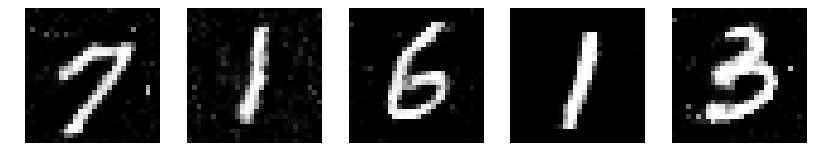

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
# 拿出5個examples
examples = 5
# 準備五個靈感
noise = np.random.normal(0, 1, (examples, random_dim))
# 使用創作者開始創作
gen_imgs = generator.predict(noise)

# 這裡要注意一下, 必須讓-1-1回到0-1才能被正確印出來
gen_imgs = 0.5 * gen_imgs + 0.5
# reshape成為圖片
gen_imgs = gen_imgs.reshape(examples, 28, 28)
# 設定一下完整畫布大小
plt.figure(figsize = (14, 14))
for i in range(0, examples):
    # 將大圖分成1 * 5五小圖, 編號分別為
    # 1, 2, 3, 4, 5
    # 所以i必須+1來得到相對應的小圖
    plt.subplot(1, examples, i + 1)
    # 不打印座標軸
    plt.axis('off')
    # 秀出圖片
    plt.imshow(gen_imgs[i], cmap='gray')

In [ ]:
# 如果你使用colab
from google.colab import drive
drive.mount('/gdrive')
generator.save('/gdrive/My Drive/keras/gan/gan_gen.h5')
discriminator.save('/gdrive/My Drive/keras/gan/gan_dis.h5')